In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor

In [3]:
denton = Preprocessor.load(config_path = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton/config.json")

In [4]:
print("Available attributes:")
print(" - cumulative_precip :", type(denton.cumulative_precip))
print(" - storm_centers     :", type(denton.storm_centers))
print(" - domain_gdf        :", type(denton.domain_gdf))
print(" - watershed_gdf     :", type(denton.watershed_gdf))

Available attributes:
 - cumulative_precip : <class 'xarray.core.dataarray.DataArray'>
 - storm_centers     : <class 'pandas.core.frame.DataFrame'>
 - domain_gdf        : <class 'geopandas.geodataframe.GeoDataFrame'>
 - watershed_gdf     : <class 'geopandas.geodataframe.GeoDataFrame'>


In [5]:
import numpy as np
from shapely.geometry import mapping
from rasterio.features import geometry_mask
from affine import Affine

def sample_one_transposed_precip(
    precip_cube,            # xr.DataArray with dims: (storm_path, y, x)
    storm_centers,          # pd.DataFrame with columns: ['storm_path','x','y']
    watershed_gdf,          # GeoDataFrame in SAME CRS/grid as precip_cube
    x_new: float,
    y_new: float,
    seed: int | None = None,
):
    """
    Randomly pick one storm (storm_path), shift it from its original center
    to (x_new, y_new), truncate wrapped edges, mask to watershed, and return
    watershed-average precipitation (mm).
    """
    rng = np.random.default_rng(seed)

    # Grid & transform from the cube
    x_coords = precip_cube.coords["x"].values
    y_coords = precip_cube.coords["y"].values
    dx = float(np.mean(np.diff(x_coords)))
    dy = float(np.mean(np.diff(y_coords)))

    transform = (Affine.translation(x_coords[0] - dx/2.0, y_coords[0] - dy/2.0)
                 * Affine.scale(dx, dy))

    # Watershed mask (True inside watershed)
    ws_mask = geometry_mask(
        geometries=[mapping(geom) for geom in watershed_gdf.geometry],
        out_shape=(len(y_coords), len(x_coords)),
        transform=transform,
        invert=True,
    )

    # Pick a random storm
    storm_paths = precip_cube.coords["storm_path"].values
    storm_path = rng.choice(storm_paths)
    storm_idx = int(np.where(storm_paths == storm_path)[0][0])

    # Original center of that storm
    centers = storm_centers.set_index("storm_path")
    if storm_path not in centers.index:
        raise ValueError(f"storm_path '{storm_path}' not found in storm_centers.")

    x_orig, y_orig = centers.loc[storm_path, ["x", "y"]]

    # Cell shifts to move center → (x_new, y_new)
    dx_cells = int(round((x_new - x_orig) / dx))
    dy_cells = int(round((y_new - y_orig) / dy))

    # Shift (roll) and zero-out wrapped edges
    precip = precip_cube.isel(storm_path=storm_idx).values  # (y, x)
    shifted = np.roll(precip, shift=(dy_cells, dx_cells), axis=(0, 1)).astype(float)

    if dy_cells > 0:
        shifted[:dy_cells, :] = 0
    elif dy_cells < 0:
        shifted[dy_cells:, :] = 0

    if dx_cells > 0:
        shifted[:, :dx_cells] = 0
    elif dx_cells < 0:
        shifted[:, dx_cells:] = 0

    # Watershed-average (NaNs -> 0, mask outside)
    shifted = np.where(np.isnan(shifted), 0.0, shifted)
    masked = np.where(ws_mask, shifted, 0.0)

    ws_ncells = int(ws_mask.sum())
    if ws_ncells == 0:
        raise ValueError("Watershed mask is empty; check CRS/grid alignment.")

    precip_avg_mm = masked.sum() / ws_ncells

    return {
        "storm_path": str(storm_path),
        "x_orig": float(x_orig), "y_orig": float(y_orig),
        "dx_cells": int(dx_cells), "dy_cells": int(dy_cells),
        "precip_avg_mm": float(precip_avg_mm),
    }

In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Point
from shapely.ops import unary_union

np.random.seed(42)

# Use your domain GeoDataFrame; adapt the name if needed
domain_gdf = denton.domain_gdf.copy()
domain_gdf = domain_gdf.explode(index_parts=False).reset_index(drop=True)
domain_geom = unary_union(domain_gdf.geometry.values)
assert domain_geom.is_valid

xmin, ymin, xmax, ymax = domain_geom.bounds
bbox_geom = box(xmin, ymin, xmax, ymax)

A_domain = domain_geom.area
A_bbox   = bbox_geom.area

A_domain, A_bbox

(919751892774.4385, 1726372206862.3167)

In [7]:
# Total budget split into iterations
N_total = 20000
T = 100
B = N_total // T   # batch per iteration

# Split controls
n_min_to_split = 10          # min samples in a leaf before it can be split
max_depth = 20               # safety cap
min_leaf_area_frac = 1e-5    # don't keep children with negligible area
eps_var = 1e-12              # tiny epsilon in scores

# (Optional) exceedance thresholds for quick diagnostics later
tau_grid = np.linspace(0, 200, 41)  # edit after you see g-scale

In [10]:
# Root leaf = bbox; we will only accept points inside domain
root_box = bbox_geom
root_area_in_domain = root_box.intersection(domain_geom).area  # equals A_domain

leaves = pd.DataFrame([{
    "leaf_id": 0,
    "x_min": xmin, "x_max": xmax, "y_min": ymin, "y_max": ymax,
    "area_in_domain": root_area_in_domain,
    "n": 0, "mean": 0.0, "m2": 0.0, "var": np.nan,
    "depth": 0, "active": True, "alloc": 0
}])

leaves

,leaf_id,x_min,x_max,y_min,y_max,area_in_domain,n,mean,m2,var,depth,active,alloc
0,0,-315046.535275,1.362324e+06,415548.678398,1.444762e+06,9.197519e+11,0,0.0,0.0,NaN,0,True,0


/tmp/ipykernel_57495/3535816016.py:67: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right")


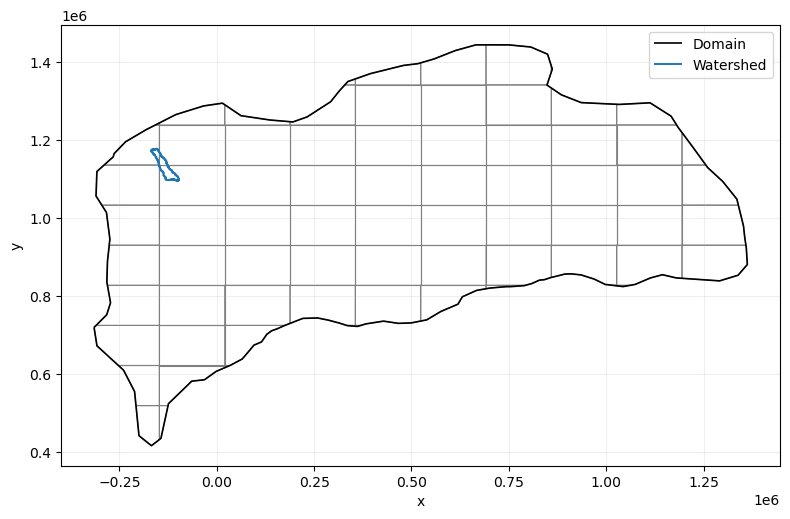

In [18]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
watershed_gdf = denton.watershed_gdf
# --- Parameters ---
nx0, ny0 = 10, 10  # 10×10 grid

# --- Bounds & cell size from domain polygon ---
xmin, ymin, xmax, ymax = domain_geom.bounds
dx = (xmax - xmin) / nx0
dy = (ymax - ymin) / ny0

# --- Build rectangles and clip each to the domain polygon ---
rows = []
for i in range(nx0):
    for j in range(ny0):
        x0 = xmin + i * dx
        x1 = xmin + (i + 1) * dx
        y0 = ymin + j * dy
        y1 = ymin + (j + 1) * dy
        rect = box(x0, y0, x1, y1)
        clipped = rect.intersection(domain_geom)
        if not clipped.is_empty and clipped.area > 0:
            rows.append({
                "i": i, "j": j,
                "x_min": x0, "x_max": x1, "y_min": y0, "y_max": y1,
                "area_in_domain": clipped.area,
                "geometry": clipped
            })

# GeoDataFrame of clipped cells
grid_clipped_gdf = gpd.GeoDataFrame(rows, geometry="geometry", crs=domain_gdf.crs)

# (Optional) also keep the original rectangles for reference/outlines only:
grid_rects = [box(xmin + i*dx, ymin + j*dy, xmin + (i+1)*dx, ymin + (j+1)*dy)
              for i in range(nx0) for j in range(ny0)]
grid_rects_gdf = gpd.GeoDataFrame({"i_j": [f"{i},{j}" for i in range(nx0) for j in range(ny0)]},
                                  geometry=grid_rects, crs=domain_gdf.crs)

# Ensure watershed is in same CRS as domain
ws_plot = watershed_gdf if watershed_gdf.crs == domain_gdf.crs else watershed_gdf.to_crs(domain_gdf.crs)

# --- Plot: domain, watershed, clipped grid ---
fig, ax = plt.subplots(figsize=(8,8))

# Domain boundary
gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).boundary.plot(
    ax=ax, color="black", linewidth=1.2, label="Domain"
)

# Watershed boundary
ws_plot.boundary.plot(ax=ax, color="tab:blue", linewidth=1.4, label="Watershed")

# Clipped grid cells (only the part inside domain)
grid_clipped_gdf.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.8, label="10×10 grid (clipped)")

# (Optional) label each clipped cell by its (i,j) index
# for idx, r in grid_clipped_gdf.iterrows():
#     c = r.geometry.representative_point()  # safer than centroid for concave polys
#     ax.text(c.x, c.y, f"{r['i']},{r['j']}", fontsize=6, ha="center", va="center", alpha=0.6)

ax.set_aspect("equal")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title("")
ax.grid(True, alpha=0.2)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [9]:
# --- Initial grid of leaves (10x10) instead of a single root leaf ---
nx0, ny0 = 10, 10  # <- change as you like

# domain bbox already defined:
# xmin, ymin, xmax, ymax ; domain_geom ; A_domain

dx0 = (xmax - xmin) / nx0
dy0 = (ymax - ymin) / ny0

rows = []
leaf_id = 0
for i in range(nx0):
    for j in range(ny0):
        x0 = xmin + i * dx0
        x1 = xmin + (i + 1) * dx0
        y0 = ymin + j * dy0
        y1 = ymin + (j + 1) * dy0
        b = box(x0, y0, x1, y1)
        a_in = b.intersection(domain_geom).area
        if a_in > 0:  # keep only bins that intersect the polygon
            rows.append({
                "leaf_id": leaf_id,
                "x_min": x0, "x_max": x1, "y_min": y0, "y_max": y1,
                "area_in_domain": a_in,
                "n": 0, "mean": 0.0, "m2": 0.0, "var": np.nan,
                "depth": 0, "active": True, "alloc": 0
            })
            leaf_id += 1

leaves = pd.DataFrame(rows).reset_index(drop=True)
print(f"Initial active leaves: {len(leaves)} (from {nx0*ny0} bins)")
leaves.head()

Initial active leaves: 73 (from 100 bins)


,leaf_id,x_min,x_max,y_min,y_max,area_in_domain,n,mean,m2,var,depth,active,alloc
0,0,-315046.535275,-147309.490946,415548.678398,518470.022563,5.121610e+09,0,0.0,0.0,NaN,0,True,0
1,1,-315046.535275,-147309.490946,518470.022563,621391.366728,7.686395e+09,0,0.0,0.0,NaN,0,True,0
2,2,-315046.535275,-147309.490946,621391.366728,724312.710893,1.530571e+10,0,0.0,0.0,NaN,0,True,0
3,3,-315046.535275,-147309.490946,724312.710893,827234.055058,1.388227e+10,0,0.0,0.0,NaN,0,True,0
4,4,-315046.535275,-147309.490946,827234.055058,930155.399223,1.367744e+10,0,0.0,0.0,NaN,0,True,0


In [11]:
samples = pd.DataFrame(columns=["iter","leaf_id","x","y","g"])
samples

,iter,leaf_id,x,y,g


In [15]:
alloc_act

0    200
Name: area_in_domain, dtype: int64

In [12]:
# --- Cell 5 (robust allocation only to ACTIVE leaves) ---

t = 1  # set your current iteration

# Active leaves index (labels)
act_idx = leaves.index[leaves["active"]].to_list()

if len(act_idx) == 0:
    raise RuntimeError("No active leaves to allocate to.")

# Build scores ONLY for active leaves
scores = pd.Series(0.0, index=act_idx)
scores.loc[act_idx] = (
    leaves.loc[act_idx, "var"].fillna(0.0) + eps_var
) * leaves.loc[act_idx, "area_in_domain"].astype(float)

# First iter or no data? fallback to area-only
if (leaves.loc[act_idx, "n"] <= 0).all() or scores.sum() <= 0:
    # Equal to area (or equal share if all areas equal)
    base = leaves.loc[act_idx, "area_in_domain"].astype(float)
    if base.sum() <= 0:
        # absolute fallback: equal allocation across active leaves
        base = pd.Series(1.0, index=act_idx)
    scores = base

# Allocate B across ACTIVES only
alloc_act = np.floor(B * scores / scores.sum()).astype(int)

# Ensure at least 1 per active leaf
alloc_act[alloc_act < 1] = 1

# Fix rounding so total equals B (use .loc with label from idxmax)
while alloc_act.sum() < B:
    idx = alloc_act.idxmax()         # label of current max
    alloc_act.loc[idx] += 1

while alloc_act.sum() > B:
    idx = alloc_act.idxmax()
    # prevent dropping a leaf to zero
    if alloc_act.loc[idx] > 1:
        alloc_act.loc[idx] -= 1
    else:
        # pick next-largest that has >1
        candidates = alloc_act[alloc_act > 1]
        if not candidates.empty:
            idx2 = candidates.idxmax()
            alloc_act.loc[idx2] -= 1
        else:
            break  # all are 1; can't reduce further without violating constraint

# Write back: zero everywhere, fill only active rows
leaves.loc[:, "alloc"] = 0
leaves.loc[alloc_act.index, "alloc"] = alloc_act.values

print("Active leaves:", len(act_idx))
print("Planned total alloc (active):", int(leaves.loc[leaves["active"], "alloc"].sum()))
print("Planned total alloc (all):   ", int(leaves["alloc"].sum()))
display(leaves.loc[leaves["active"], ["leaf_id","alloc","n","var","area_in_domain"]])


Active leaves: 1
Planned total alloc (active): 200
Planned total alloc (all):    200


,leaf_id,alloc,n,var,area_in_domain
0,0,200,0,NaN,9.197519e+11


In [20]:
# Step 2
# Draw samples leaf-by-leaf
new_rows = []
for idx, row in leaves[leaves["active"]].iterrows():
    K = int(row["alloc"])
    if K <= 0: 
        continue

    x0, x1 = row["x_min"], row["x_max"]
    y0, y1 = row["y_min"], row["y_max"]
    box_leaf = box(x0, y0, x1, y1)

    kept = 0
    attempts = 0
    xs = []
    ys = []

    while kept < K and attempts < K * 50:  # generous cap
        attempts += 1
        xr = np.random.uniform(x0, x1)
        yr = np.random.uniform(y0, y1)
        if domain_geom.contains(Point(xr, yr)):
            xs.append(xr); ys.append(yr)
            kept += 1

    # append to 'samples' (g to be filled next cell)
    for k in range(K):
        new_rows.append({"iter": t, "leaf_id": row["leaf_id"], "x": xs[k], "y": ys[k], "g": np.nan})

len(new_rows), sum(leaves["alloc"])

(200, 200)

In [22]:
#Step 3
new_df = pd.DataFrame(new_rows).reset_index(drop=True)

# Compute watershed-avg precip for each sample by randomly picking a storm and transposing
g_vals = np.empty(len(new_df), dtype=float)
storm_used = np.empty(len(new_df), dtype=object)
dx_cells_used = np.empty(len(new_df), dtype=int)
dy_cells_used = np.empty(len(new_df), dtype=int)
x_orig_used = np.empty(len(new_df), dtype=float)
y_orig_used = np.empty(len(new_df), dtype=float)

for i in new_df.index:
    x_new = float(new_df.at[i, "x"])
    y_new = float(new_df.at[i, "y"])

    out = sample_one_transposed_precip(
        precip_cube=denton.cumulative_precip,
        storm_centers=denton.storm_centers,
        watershed_gdf=denton.watershed_gdf,
        x_new=x_new,
        y_new=y_new,
        seed=None,          # or set an int for reproducibility
    )

    g_vals[i]         = out["precip_avg_mm"]
    storm_used[i]     = out["storm_path"]
    dx_cells_used[i]  = out["dx_cells"]
    dy_cells_used[i]  = out["dy_cells"]
    x_orig_used[i]    = out["x_orig"]
    y_orig_used[i]    = out["y_orig"]

# Attach results
new_df["g"] = g_vals
new_df["storm_path"] = storm_used
new_df["dx_cells"] = dx_cells_used
new_df["dy_cells"] = dy_cells_used
new_df["x_orig"] = x_orig_used
new_df["y_orig"] = y_orig_used

# Append to the running samples table
samples = pd.concat([samples, new_df], ignore_index=True)

new_df.head()


/tmp/ipykernel_57495/249232171.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  samples = pd.concat([samples, new_df], ignore_index=True)


,iter,leaf_id,x,y,g,storm_path,dx_cells,dy_cells,x_orig,y_orig
0,1,0,912778.467387,1.031696e+06,0.000000,19861107_72hr_st1_r288,92,-60,546000.0,1270000.0
1,1,0,693246.018441,1.144306e+06,0.264912,20091109_72hr_st2_r156,-91,-5,1058000.0,1166000.0
2,1,0,-10058.709430,6.043111e+05,0.000000,20020330_72hr_st1_r379,-104,-165,406000.0,1266000.0
3,1,0,195280.410666,9.556351e+05,0.000000,19950215_72hr_st1_r409,-169,-92,870000.0,1322000.0
4,1,0,174988.263343,7.926132e+05,22.408775,20000503_72hr_st3_r297,-34,4,310000.0,778000.0


In [23]:
#Step 4
# Update each active leaf with its new samples (Welford's online algorithm)
for leaf_id in leaves.loc[leaves["active"], "leaf_id"].tolist():
    sel = new_df["leaf_id"] == leaf_id
    vals = new_df.loc[sel, "g"].to_numpy()
    if vals.size == 0:
        continue

    j = leaves.index[leaves["leaf_id"] == leaf_id][0]
    n = int(leaves.at[j, "n"])
    mean = float(leaves.at[j, "mean"])
    m2 = float(leaves.at[j, "m2"])

    for v in vals:
        n += 1
        delta = v - mean
        mean += delta / n
        m2 += delta * (v - mean)

    leaves.at[j, "n"] = n
    leaves.at[j, "mean"] = mean
    leaves.at[j, "m2"] = m2
    leaves.at[j, "var"] = (m2 / (n - 1)) if n > 1 else np.nan

leaves[["leaf_id","n","mean","var","area_in_domain","depth","active"]]

,leaf_id,n,mean,var,area_in_domain,depth,active
0,0,200,22.395987,1890.98206,9.197519e+11,0,True


In [230]:
# Step 5
# Mean estimate
area_w = leaves["area_in_domain"] / A_domain
E_g_hat = (area_w * leaves["mean"].fillna(0.0)).sum()

# Exceedance curve (optional)
exceed = []
for tau in tau_grid:
    tail_frac = []
    for _, row in leaves.iterrows():
        if row["n"] > 0:
            leaf_g = samples.loc[(samples["leaf_id"]==row["leaf_id"]) & (samples["iter"]==t), "g"]
            # you can also use all accumulated in that leaf: samples["leaf_id"]==row["leaf_id"]
            if leaf_g.size > 0:
                tail_frac.append( (leaf_g > tau).mean() * (row["area_in_domain"]/A_domain) )
            else:
                tail_frac.append(0.0)
        else:
            tail_frac.append(0.0)
    exceed.append(np.sum(tail_frac))

E_g_hat, exceed[:5]

(np.float64(124.74705587264458),
 [np.float64(0.3546032684153342),
  np.float64(0.3088630073389759),
  np.float64(0.30369258891115425),
  np.float64(0.28334279351987623),
  np.float64(0.2696902036035066)])

In [231]:
#Step 6
# Choose leaves to split (here: split up to 1 leaf per iteration as a simple policy)
candidates = leaves[
    (leaves["active"]) &
    (leaves["n"] >= n_min_to_split) &
    (leaves["depth"] < max_depth)
].copy()

candidates["score"] = candidates["var"].fillna(0.0) * candidates["area_in_domain"]

if candidates.shape[0] > 0 and candidates["score"].max() > 0:
    # pick the single highest-score leaf
    j = candidates.sort_values("score", ascending=False).index[0]
    leaf = leaves.loc[j].copy()

    # split along the longer axis
    width  = leaf["x_max"] - leaf["x_min"]
    height = leaf["y_max"] - leaf["y_min"]
    split_along_x = (width >= height)

    if split_along_x:
        x_mid = 0.5 * (leaf["x_min"] + leaf["x_max"])
        child_boxes = [
            box(leaf["x_min"], leaf["y_min"], x_mid,           leaf["y_max"]),
            box(x_mid,           leaf["y_min"], leaf["x_max"], leaf["y_max"]),
        ]
    else:
        y_mid = 0.5 * (leaf["y_min"] + leaf["y_max"])
        child_boxes = [
            box(leaf["x_min"], leaf["y_min"], leaf["x_max"], y_mid),
            box(leaf["x_min"], y_mid,          leaf["x_max"], leaf["y_max"]),
        ]

    new_rows = []
    next_id = int(leaves["leaf_id"].max()) + 1

    for b in child_boxes:
        area_in_dom = b.intersection(domain_geom).area
        if area_in_dom >= min_leaf_area_frac * A_domain:
            new_rows.append({
                "leaf_id": next_id,
                "x_min": b.bounds[0], "x_max": b.bounds[2],
                "y_min": b.bounds[1], "y_max": b.bounds[3],
                "area_in_domain": area_in_dom,
                "n": 0, "mean": 0.0, "m2": 0.0, "var": np.nan,
                "depth": int(leaf["depth"]) + 1,
                "active": True, "alloc": 0
            })
            next_id += 1

    # deactivate parent
    leaves.at[j, "active"] = False
    leaves.at[j, "alloc"] = 0

    if new_rows:
        leaves = pd.concat([leaves, pd.DataFrame(new_rows)], ignore_index=True)

leaves.sort_values(["active","depth","leaf_id"])

,leaf_id,x_min,x_max,y_min,y_max,area_in_domain,n,mean,m2,var,depth,active,alloc
0,0,-315046.535275,1.362324e+06,4.155487e+05,1.444762e+06,9.197519e+11,200,15.968211,222335.256634,1117.262596,0,False,0
1,1,-315046.535275,5.236387e+05,4.155487e+05,1.444762e+06,5.150320e+11,112,36.077318,229478.058741,2067.369899,1,False,0
2,2,523638.686370,1.362324e+06,4.155487e+05,1.444762e+06,4.047198e+11,286,3.124877,31528.639821,110.626806,1,False,0
3,3,-315046.535275,5.236387e+05,4.155487e+05,9.301554e+05,2.262769e+11,172,17.022939,157371.530211,920.301346,2,False,0
4,4,-315046.535275,5.236387e+05,9.301554e+05,1.444762e+06,2.887551e+11,63,52.743372,172326.387764,2779.457867,2,False,0
6,6,523638.686370,1.362324e+06,9.301554e+05,1.444762e+06,3.190331e+11,317,3.494864,36496.082601,115.493932,2,False,0
7,7,-315046.535275,1.042961e+05,9.301554e+05,1.444762e+06,1.253629e+11,118,79.239548,456530.530589,3901.970347,3,False,0
8,8,104296.075548,5.236387e+05,9.301554e+05,1.444762e+06,1.633922e+11,297,20.122399,220751.612338,745.782474,3,False,0
9,9,-315046.535275,1.042961e+05,4.155487e+05,9.301554e+05,1.415147e+11,151,18.804711,147010.679932,980.071200,3,False,0
13,13,-315046.535275,1.042961e+05,9.301554e+05,1.187459e+06,1.007795e+11,76,82.217117,408890.310683,5451.870809,4,False,0


/tmp/ipykernel_41618/3844464381.py:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right")
/tmp/ipykernel_41618/3844464381.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


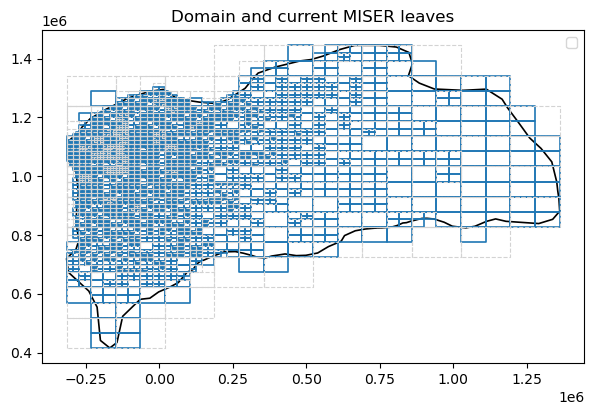

In [23]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box

# Build a GeoDataFrame of rectangular leaves (polygons) from the current `leaves` table
leaf_polys = []
for _, r in leaves.iterrows():
    leaf_polys.append(box(r["x_min"], r["y_min"], r["x_max"], r["y_max"]))
leaf_gdf = gpd.GeoDataFrame(leaves.copy(), geometry=leaf_polys, crs=domain_gdf.crs)

fig, ax = plt.subplots(figsize=(7,7))
# Domain
gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.2, label="Domain")

# Active leaves in one style, inactive in lighter style
leaf_gdf.loc[leaf_gdf["active"]].plot(ax=ax, facecolor="none", edgecolor="tab:blue", linewidth=1.2, label="Active leaf")
leaf_gdf.loc[~leaf_gdf["active"]].plot(ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.8, linestyle="--", label="Inactive leaf")

ax.set_title("Domain and current MISER leaves")
ax.set_aspect("equal")
ax.legend(loc="upper right")
plt.show()

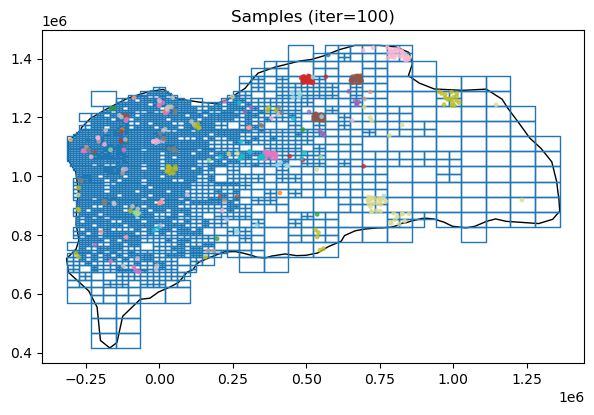

In [24]:
fig, ax = plt.subplots(figsize=(7,7))
gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.0)

# Draw leaves
leaf_gdf.loc[leaf_gdf["active"]].plot(ax=ax, facecolor="none", edgecolor="tab:blue", linewidth=1.0)

# Choose samples to show:
show_all_samples = False  # <-- switch to True to show all iterations
if show_all_samples:
    S = samples.copy()
    title_suffix = " (all iters)"
else:
    S = samples.loc[samples["iter"]==t].copy()  # current iteration `t`
    title_suffix = f" (iter={t})"

# Plot samples (small dots); color by leaf id to see allocation
if not S.empty:
    ax.scatter(S["x"], S["y"], s=6, alpha=0.7, c=S["leaf_id"], cmap="tab20", marker="o")

ax.set_title(f"Samples{title_suffix}")
ax.set_aspect("equal")
plt.show()

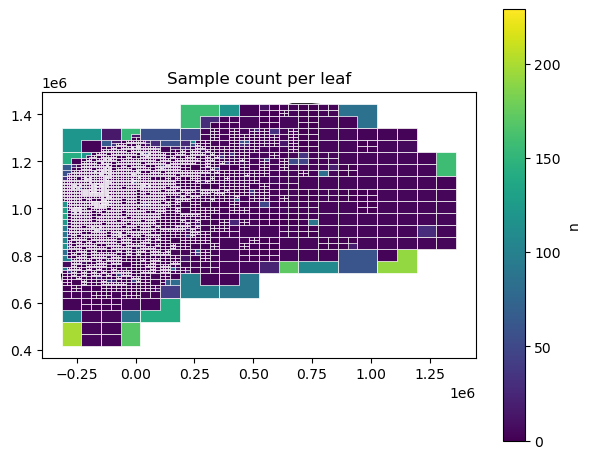

In [25]:
metric = "n"   # choose "n" for count or "var" for variance
title_map = {"n":"Sample count per leaf", "var":"Variance per leaf"}

# Copy current leaves and set a color column
leaf_plot = leaf_gdf.copy()
vals = leaf_plot[metric].fillna(0.0)
# Avoid degenerate all-zeros for colormap
vmax = max(vals.max(), 1e-12)

fig, ax = plt.subplots(figsize=(7,7))
gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.0)
leaf_plot.plot(ax=ax, column=metric, cmap="viridis", vmin=0, vmax=vmax, linewidth=0.5, edgecolor="white")
ax.set_title(title_map[metric])
ax.set_aspect("equal")

# Optional colorbar
mappable = plt.cm.ScalarMappable(cmap="viridis")
mappable.set_array(vals)
mappable.set_clim(0, vmax)
cb = plt.colorbar(mappable, ax=ax, shrink=0.8)
cb.set_label(metric)

plt.show()

/tmp/ipykernel_41618/488544924.py:19: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right")
/tmp/ipykernel_41618/488544924.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


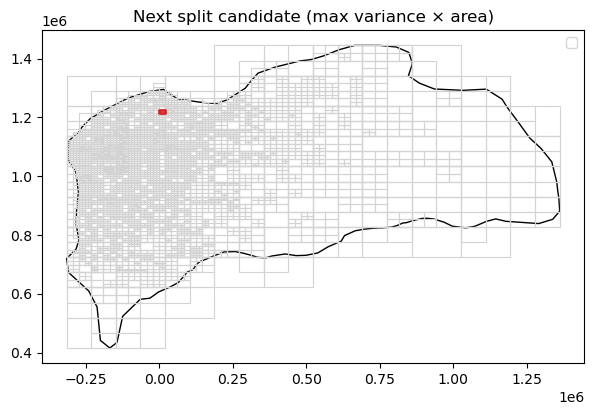

In [26]:
viz = leaves.copy()
viz["score"] = viz["var"].fillna(0.0) * viz["area_in_domain"]
j_star = viz.loc[(viz["active"]) & (viz["n"]>0), "score"].idxmax() if (viz["active"] & (viz["n"]>0)).any() else None

fig, ax = plt.subplots(figsize=(7,7))
gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.0)

# Draw all leaves
leaf_gdf.plot(ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.8)

# Highlight candidate to split
if j_star is not None and not np.isnan(viz.at[j_star, "score"]):
    gpd.GeoSeries([leaf_gdf.loc[j_star, "geometry"]], crs=leaf_gdf.crs).plot(
        ax=ax, facecolor="none", edgecolor="tab:red", linewidth=2.0, label="Next split?"
    )

ax.set_title("Next split candidate (max variance × area)")
ax.set_aspect("equal")
ax.legend(loc="upper right")
plt.show()

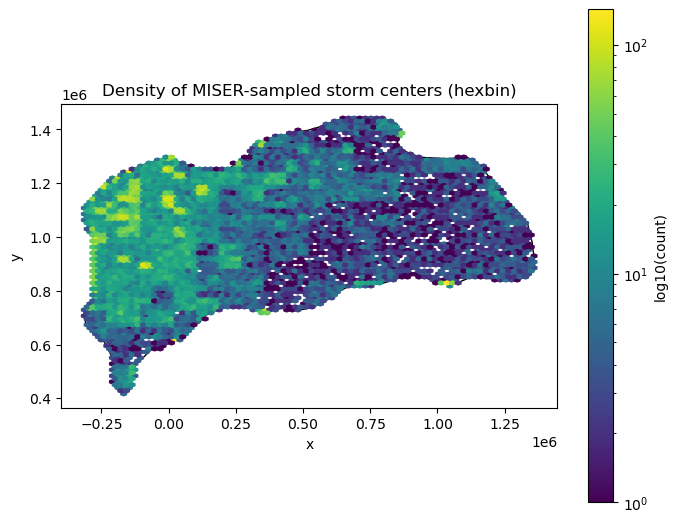

In [21]:
fig, ax = plt.subplots(figsize=(8,8))

# Domain boundary
gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).plot(
    ax=ax, facecolor="none", edgecolor="black", linewidth=1.0
)

# All samples (thin if too many)
S_all = samples.copy()
max_points_to_plot = 300000
if len(S_all) > max_points_to_plot:
    S_all = S_all.sample(max_points_to_plot, random_state=42)

hb = ax.hexbin(
    S_all["x"], S_all["y"],
    gridsize=80,           # smaller = finer resolution
    bins="log",            # log color scale, good for skewed counts
    cmap="viridis"
)
cbar = plt.colorbar(hb, ax=ax, shrink=0.8)
cbar.set_label("log10(count)")

ax.set_title("Density of MISER-sampled storm centers (hexbin)")
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()


In [12]:
# === Automatic MISER loop: 100 iterations ===
# Prereqs: leaves (root leaf initialized), samples DataFrame created, and all the config vars set.

N_iters = 100

for t in range(1, N_iters + 1):
    # -------------------------------
    # Step 1: Allocate to ACTIVE leaves (robust)
    # -------------------------------
    act_idx = leaves.index[leaves["active"]].to_list()
    if len(act_idx) == 0:
        raise RuntimeError(f"[iter {t}] No active leaves to allocate to.")

    scores = pd.Series(0.0, index=act_idx)
    scores.loc[act_idx] = (
        leaves.loc[act_idx, "var"].fillna(0.0) + eps_var
    ) * leaves.loc[act_idx, "area_in_domain"].astype(float)

    if (leaves.loc[act_idx, "n"] <= 0).all() or scores.sum() <= 0:
        base = leaves.loc[act_idx, "area_in_domain"].astype(float)
        if base.sum() <= 0:
            base = pd.Series(1.0, index=act_idx)
        scores = base

    alloc_act = np.floor(B * scores / scores.sum()).astype(int)
    alloc_act[alloc_act < 1] = 1  # at least 1 per active leaf

    while alloc_act.sum() < B:
        idx = alloc_act.idxmax()     # label-based
        alloc_act.loc[idx] += 1
    while alloc_act.sum() > B:
        idx = alloc_act.idxmax()
        if alloc_act.loc[idx] > 1:
            alloc_act.loc[idx] -= 1
        else:
            candidates = alloc_act[alloc_act > 1]
            if not candidates.empty:
                idx2 = candidates.idxmax()
                alloc_act.loc[idx2] -= 1
            else:
                break

    leaves.loc[:, "alloc"] = 0
    leaves.loc[alloc_act.index, "alloc"] = alloc_act.values

    # -------------------------------
    # Step 2: Sample uniformly inside each leaf ∩ domain
    # -------------------------------
    new_rows = []
    for _, row in leaves[leaves["active"]].iterrows():
        K_target = int(row["alloc"])
        if K_target <= 0:
            continue

        x0, x1 = row["x_min"], row["x_max"]
        y0, y1 = row["y_min"], row["y_max"]

        kept = 0
        attempts = 0
        xs = []
        ys = []

        # Try harder for tiny/sliver leaves
        max_attempts = max(K_target * 200, 5000)

        while kept < K_target and attempts < max_attempts:
            attempts += 1
            xr = np.random.uniform(x0, x1)
            yr = np.random.uniform(y0, y1)
            if domain_geom.contains(Point(xr, yr)):
                xs.append(xr); ys.append(yr)
                kept += 1

        if kept < K_target:
            # Shortfall: we’ll proceed with what we actually got (avoids IndexError)
            print(f"[iter {t}] WARN leaf {int(row['leaf_id'])}: "
                f"planned={K_target}, kept={kept}, attempts={attempts}")

        # Append only the samples we actually kept
        for k in range(kept):
            new_rows.append({
                "iter": t,
                "leaf_id": row["leaf_id"],
                "x": xs[k],
                "y": ys[k],
                "g": np.nan
            })

    # -------------------------------
    # Step 3: Evaluate g(x,y) by randomly picking a storm and transposing
    # -------------------------------
    new_df = pd.DataFrame(new_rows).reset_index(drop=True)

    g_vals = np.empty(len(new_df), dtype=float)
    storm_used = np.empty(len(new_df), dtype=object)
    dx_cells_used = np.empty(len(new_df), dtype=int)
    dy_cells_used = np.empty(len(new_df), dtype=int)
    x_orig_used = np.empty(len(new_df), dtype=float)
    y_orig_used = np.empty(len(new_df), dtype=float)

    # Per-sample transposition using your earlier helper function
    for i in new_df.index:
        x_new = float(new_df.at[i, "x"])
        y_new = float(new_df.at[i, "y"])

        out = sample_one_transposed_precip(
            precip_cube=denton.cumulative_precip,
            storm_centers=denton.storm_centers,
            watershed_gdf=denton.watershed_gdf,
            x_new=x_new,
            y_new=y_new,
            seed=None,
        )

        g_vals[i]         = out["precip_avg_mm"]
        storm_used[i]     = out["storm_path"]
        dx_cells_used[i]  = out["dx_cells"]
        dy_cells_used[i]  = out["dy_cells"]
        x_orig_used[i]    = out["x_orig"]
        y_orig_used[i]    = out["y_orig"]

    new_df["g"] = g_vals
    new_df["storm_path"] = storm_used
    new_df["dx_cells"] = dx_cells_used
    new_df["dy_cells"] = dy_cells_used
    new_df["x_orig"] = x_orig_used
    new_df["y_orig"] = y_orig_used

    samples = pd.concat([samples, new_df], ignore_index=True)

    # -------------------------------
    # Step 4: Update Welford stats per active leaf
    # -------------------------------
    for leaf_id in leaves.loc[leaves["active"], "leaf_id"].tolist():
        sel = new_df["leaf_id"] == leaf_id
        vals = new_df.loc[sel, "g"].to_numpy()
        if vals.size == 0:
            continue

        j = leaves.index[leaves["leaf_id"] == leaf_id][0]
        n = int(leaves.at[j, "n"])
        mean = float(leaves.at[j, "mean"])
        m2 = float(leaves.at[j, "m2"])

        for v in vals:
            n += 1
            delta = v - mean
            mean += delta / n
            m2 += delta * (v - mean)

        leaves.at[j, "n"] = n
        leaves.at[j, "mean"] = mean
        leaves.at[j, "m2"] = m2
        leaves.at[j, "var"] = (m2 / (n - 1)) if n > 1 else np.nan

    # -------------------------------
    # Step 5: (optional) diagnostics this iter — mean & exceedance tail
    # -------------------------------
    area_w = leaves["area_in_domain"] / A_domain
    E_g_hat = (area_w * leaves["mean"].fillna(0.0)).sum()

    # quick tail at a few taus (optional; comment if slow)
    # exceed = []
    # for tau in tau_grid:
    #     tail_frac = []
    #     for _, r in leaves.iterrows():
    #         if r["n"] > 0:
    #             leaf_g = samples.loc[(samples["leaf_id"]==r["leaf_id"]) & (samples["iter"]==t), "g"]
    #             if leaf_g.size > 0:
    #                 tail_frac.append((leaf_g > tau).mean() * (r["area_in_domain"]/A_domain))
    #             else:
    #                 tail_frac.append(0.0)
    #         else:
    #             tail_frac.append(0.0)
    #     exceed.append(np.sum(tail_frac))

    if t % 5 == 0 or t == 1:
        print(f"[iter {t:3d}] active={int(leaves['active'].sum())}  "
              f"samples_added={len(new_df):5d}  "
              f"E[g]~{E_g_hat:0.3f}")

    # -------------------------------
    # Step 6: Split one highest-score leaf (variance × area)
    # -------------------------------
    candidates = leaves[
        (leaves["active"]) &
        (leaves["n"] >= n_min_to_split) &
        (leaves["depth"] < max_depth)
    ].copy()
    candidates["score"] = candidates["var"].fillna(0.0) * candidates["area_in_domain"]

    if candidates.shape[0] > 0 and candidates["score"].max() > 0:
        j = candidates.sort_values("score", ascending=False).index[0]
        leaf = leaves.loc[j].copy()

        width  = leaf["x_max"] - leaf["x_min"]
        height = leaf["y_max"] - leaf["y_min"]
        split_along_x = (width >= height)

        if split_along_x:
            x_mid = 0.5 * (leaf["x_min"] + leaf["x_max"])
            child_boxes = [
                box(leaf["x_min"], leaf["y_min"], x_mid,           leaf["y_max"]),
                box(x_mid,           leaf["y_min"], leaf["x_max"], leaf["y_max"]),
            ]
        else:
            y_mid = 0.5 * (leaf["y_min"] + leaf["y_max"])
            child_boxes = [
                box(leaf["x_min"], leaf["y_min"], leaf["x_max"], y_mid),
                box(leaf["x_min"], y_mid,          leaf["x_max"], leaf["y_max"]),
            ]

        new_leaf_rows = []
        next_id = int(leaves["leaf_id"].max()) + 1

        for b in child_boxes:
            area_in_dom = b.intersection(domain_geom).area
            if area_in_dom >= min_leaf_area_frac * A_domain:
                new_leaf_rows.append({
                    "leaf_id": next_id,
                    "x_min": b.bounds[0], "x_max": b.bounds[2],
                    "y_min": b.bounds[1], "y_max": b.bounds[3],
                    "area_in_domain": area_in_dom,
                    "n": 0, "mean": 0.0, "m2": 0.0, "var": np.nan,
                    "depth": int(leaf["depth"]) + 1,
                    "active": True, "alloc": 0
                })
                next_id += 1

        # deactivate parent
        leaves.at[j, "active"] = False
        leaves.at[j, "alloc"] = 0

        if new_leaf_rows:
            leaves = pd.concat([leaves, pd.DataFrame(new_leaf_rows)], ignore_index=True)

# === After 100 iters: recompute final per-leaf stats using ALL samples & report mean ===
for idx, row in leaves.iterrows():
    lid = row["leaf_id"]
    g_leaf = samples.loc[samples["leaf_id"]==lid, "g"].to_numpy()
    n = g_leaf.size
    leaves.at[idx, "n"] = n
    if n > 0:
        leaves.at[idx, "mean"] = g_leaf.mean()
        leaves.at[idx, "var"]  = g_leaf.var(ddof=1) if n > 1 else np.nan
    else:
        leaves.at[idx, "mean"] = 0.0
        leaves.at[idx, "var"]  = np.nan

area_w = leaves["area_in_domain"] / A_domain
E_g_hat_final = (area_w * leaves["mean"].fillna(0.0)).sum()
print(f"\nFinal area-weighted mean E[g] ≈ {E_g_hat_final:0.3f}")
print(f"Active leaves at end: {int(leaves['active'].sum())}, total leaves: {len(leaves)}")


[iter   1] active=2  samples_added=  200  E[g]~40.717
[iter   5] active=6  samples_added=  200  E[g]~77.999
[iter  10] active=10  samples_added=  200  E[g]~101.463
[iter  15] active=15  samples_added=  200  E[g]~114.337
[iter  20] active=20  samples_added=  200  E[g]~123.839
[iter  25] active=25  samples_added=  200  E[g]~132.276
[iter  30] active=29  samples_added=  200  E[g]~140.131
[iter  35] active=34  samples_added=  200  E[g]~143.208
[iter  40] active=39  samples_added=  200  E[g]~145.884
[iter  45] active=44  samples_added=  200  E[g]~151.302
[iter  50] active=49  samples_added=  200  E[g]~153.490
[iter  55] active=54  samples_added=  200  E[g]~156.850
[iter  60] active=59  samples_added=  200  E[g]~160.500
[iter  65] active=63  samples_added=  200  E[g]~162.455
[iter  70] active=68  samples_added=  200  E[g]~165.431
[iter  75] active=73  samples_added=  200  E[g]~167.955
[iter  80] active=78  samples_added=  200  E[g]~169.011
[iter  85] active=83  samples_added=  200  E[g]~172.

In [22]:
# ================================
# (A) ONE-TIME EXPLORATION PASS
# ================================
explore_per_leaf = 3  # small equal start; set 0 to skip entirely
act_idx0 = leaves.index[leaves["active"]]
need0 = int(explore_per_leaf * len(act_idx0))
print("Exploration samples needed (one-time):", need0)

alloc0 = pd.Series(0, index=leaves.index)
alloc0.loc[act_idx0] = explore_per_leaf

# If you need to cap by B in this pass, trim highest-area leaves first
if alloc0.sum() > B:
    excess = int(alloc0.sum() - B)
    order = leaves.loc[act_idx0, "area_in_domain"].sort_values(ascending=False).index
    k = 0
    while excess > 0 and k < len(order):
        if alloc0.loc[order[k]] > 0:
            alloc0.loc[order[k]] -= 1
            excess -= 1
        k += 1

leaves.loc[:, "alloc"] = 0
leaves.loc[alloc0.index, "alloc"] = alloc0.values

# ---- Exploration sampling (Step 2–4 once) ----
new_rows = []
for _, row in leaves[leaves["active"]].iterrows():
    K_target = int(row["alloc"])
    if K_target <= 0: 
        continue
    x0, x1 = row["x_min"], row["x_max"]
    y0, y1 = row["y_min"], row["y_max"]
    kept = 0; attempts = 0; xs = []; ys = []
    max_attempts = max(K_target * 200, 5000)
    while kept < K_target and attempts < max_attempts:
        attempts += 1
        xr = np.random.uniform(x0, x1)
        yr = np.random.uniform(y0, y1)
        if domain_geom.contains(Point(xr, yr)):
            xs.append(xr); ys.append(yr); kept += 1
    if kept < K_target:
        print(f"[explore] WARN leaf {int(row['leaf_id'])}: planned={K_target}, kept={kept}, attempts={attempts}")
    for k in range(kept):
        new_rows.append({"iter": 0, "leaf_id": row["leaf_id"], "x": xs[k], "y": ys[k], "g": np.nan})

new_df = pd.DataFrame(new_rows).reset_index(drop=True)

if not new_df.empty:
    g_vals = np.empty(len(new_df), dtype=float)
    storm_used = np.empty(len(new_df), dtype=object)
    dx_cells_used = np.empty(len(new_df), dtype=int)
    dy_cells_used = np.empty(len(new_df), dtype=int)
    x_orig_used = np.empty(len(new_df), dtype=float)
    y_orig_used = np.empty(len(new_df), dtype=float)
    for i in new_df.index:
        x_new = float(new_df.at[i, "x"]); y_new = float(new_df.at[i, "y"])
        out = sample_one_transposed_precip(
            precip_cube=denton.cumulative_precip,
            storm_centers=denton.storm_centers,
            watershed_gdf=denton.watershed_gdf,
            x_new=x_new, y_new=y_new, seed=None,
        )
        g_vals[i]        = out["precip_avg_mm"]
        storm_used[i]    = out["storm_path"]
        dx_cells_used[i] = out["dx_cells"]
        dy_cells_used[i] = out["dy_cells"]
        x_orig_used[i]   = out["x_orig"]
        y_orig_used[i]   = out["y_orig"]
    new_df["g"] = g_vals
    new_df["storm_path"] = storm_used
    new_df["dx_cells"] = dx_cells_used
    new_df["dy_cells"] = dy_cells_used
    new_df["x_orig"] = x_orig_used
    new_df["y_orig"] = y_orig_used
    samples = pd.concat([samples, new_df], ignore_index=True)

# Update Welford stats after exploration
for leaf_id in leaves.loc[leaves["active"], "leaf_id"].tolist():
    vals = new_df.loc[new_df["leaf_id"] == leaf_id, "g"].to_numpy() if not new_df.empty else np.asarray([])
    if vals.size == 0: 
        continue
    j = leaves.index[leaves["leaf_id"] == leaf_id][0]
    n = int(leaves.at[j, "n"]); mean = float(leaves.at[j, "mean"]); m2 = float(leaves.at[j, "m2"])
    for v in vals:
        n += 1
        delta = v - mean
        mean += delta / n
        m2 += delta * (v - mean)
    leaves.at[j, "n"] = n
    leaves.at[j, "mean"] = mean
    leaves.at[j, "m2"] = m2
    leaves.at[j, "var"] = (m2 / (n - 1)) if n > 1 else np.nan

# ================================
# (B) ADAPTIVE LOOP: 100 iterations
# ================================
N_iters = 100
K_split = 10  # split up to K leaves per iter (quad-split)

for t in range(1, N_iters + 1):

    # ---- Step 1: allocation across ACTIVE leaves (fractional) ----
    act_idx = leaves.index[leaves["active"]].to_list()
    if len(act_idx) == 0:
        raise RuntimeError(f"[iter {t}] No active leaves to allocate to.")
    scores = ((leaves.loc[act_idx, "var"].fillna(0.0) + eps_var)
              * leaves.loc[act_idx, "area_in_domain"].astype(float))
    if (leaves.loc[act_idx, "n"] <= 0).all() or scores.sum() <= 0:
        base = leaves.loc[act_idx, "area_in_domain"].astype(float)
        scores = base if base.sum() > 0 else pd.Series(1.0, index=act_idx)
    weights = scores / scores.sum()
    alloc_float = B * weights
    alloc_act = np.floor(alloc_float).astype(int)
    R = B - alloc_act.sum()
    if R > 0:
        frac = (alloc_float - alloc_act).sort_values(ascending=False)
        alloc_act.loc[frac.index[:R]] += 1
    leaves.loc[:, "alloc"] = 0
    leaves.loc[alloc_act.index, "alloc"] = alloc_act.values

    # ---- Step 2: sample uniformly in leaf ∩ domain (robust) ----
    new_rows = []
    for _, row in leaves[leaves["active"]].iterrows():
        K_target = int(row["alloc"])
        if K_target <= 0: 
            continue
        x0, x1 = row["x_min"], row["x_max"]
        y0, y1 = row["y_min"], row["y_max"]
        kept = 0; attempts = 0; xs = []; ys = []
        max_attempts = max(K_target * 200, 5000)
        while kept < K_target and attempts < max_attempts:
            attempts += 1
            xr = np.random.uniform(x0, x1)
            yr = np.random.uniform(y0, y1)
            if domain_geom.contains(Point(xr, yr)):
                xs.append(xr); ys.append(yr); kept += 1
        if kept < K_target:
            print(f"[iter {t}] WARN leaf {int(row['leaf_id'])}: planned={K_target}, kept={kept}, attempts={attempts}")
        for k in range(kept):
            new_rows.append({"iter": t, "leaf_id": row["leaf_id"], "x": xs[k], "y": ys[k], "g": np.nan})

    # ---- Step 3: evaluate g via random storm transpose ----
    new_df = pd.DataFrame(new_rows).reset_index(drop=True)
    if not new_df.empty:
        g_vals = np.empty(len(new_df), dtype=float)
        storm_used = np.empty(len(new_df), dtype=object)
        dx_cells_used = np.empty(len(new_df), dtype=int)
        dy_cells_used = np.empty(len(new_df), dtype=int)
        x_orig_used = np.empty(len(new_df), dtype=float)
        y_orig_used = np.empty(len(new_df), dtype=float)
        for i in new_df.index:
            x_new = float(new_df.at[i, "x"]); y_new = float(new_df.at[i, "y"])
            out = sample_one_transposed_precip(
                precip_cube=denton.cumulative_precip,
                storm_centers=denton.storm_centers,
                watershed_gdf=denton.watershed_gdf,
                x_new=x_new, y_new=y_new, seed=None,
            )
            g_vals[i]        = out["precip_avg_mm"]
            storm_used[i]    = out["storm_path"]
            dx_cells_used[i] = out["dx_cells"]
            dy_cells_used[i] = out["dy_cells"]
            x_orig_used[i]   = out["x_orig"]
            y_orig_used[i]   = out["y_orig"]
        new_df["g"] = g_vals
        new_df["storm_path"] = storm_used
        new_df["dx_cells"] = dx_cells_used
        new_df["dy_cells"] = dy_cells_used
        new_df["x_orig"] = x_orig_used
        new_df["y_orig"] = y_orig_used
        samples = pd.concat([samples, new_df], ignore_index=True)

    # ---- Step 4: update Welford stats per active leaf ----
    if not new_df.empty:
        for leaf_id in leaves.loc[leaves["active"], "leaf_id"].tolist():
            vals = new_df.loc[new_df["leaf_id"] == leaf_id, "g"].to_numpy()
            if vals.size == 0: 
                continue
            j = leaves.index[leaves["leaf_id"] == leaf_id][0]
            n = int(leaves.at[j, "n"]); mean = float(leaves.at[j, "mean"]); m2 = float(leaves.at[j, "m2"])
            for v in vals:
                n += 1
                delta = v - mean
                mean += delta / n
                m2 += delta * (v - mean)
            leaves.at[j, "n"] = n
            leaves.at[j, "mean"] = mean
            leaves.at[j, "m2"] = m2
            leaves.at[j, "var"] = (m2 / (n - 1)) if n > 1 else np.nan

    # ---- Step 5: diagnostics ----
    area_w = leaves["area_in_domain"] / A_domain
    E_g_hat = (area_w * leaves["mean"].fillna(0.0)).sum()
    if t % 5 == 0 or t == 1:
        print(f"[iter {t:3d}] active={int(leaves['active'].sum())}  "
              f"samples_added={len(new_df):5d}  E[g]~{E_g_hat:0.3f}")

    # ---- Step 6: split top-K leaves into 4 children (quad-split) ----
    candidates = leaves[
        (leaves["active"]) &
        (leaves["n"] >= n_min_to_split) &
        (leaves["depth"] < max_depth)
    ].copy()
    candidates["score"] = candidates["var"].fillna(0.0) * candidates["area_in_domain"]

    if candidates.shape[0] > 0 and candidates["score"].max() > 0:
        to_split_idx = candidates.sort_values("score", ascending=False).index[:K_split]
        new_leaf_rows = []
        next_id = int(leaves["leaf_id"].max()) + 1
        for j in to_split_idx:
            leaf = leaves.loc[j].copy()
            xL, xU = leaf["x_min"], leaf["x_max"]
            yL, yU = leaf["y_min"], leaf["y_max"]
            x_mid = 0.5 * (xL + xU); y_mid = 0.5 * (yL + yU)
            child_boxes = [
                box(xL,  yL,  x_mid, y_mid),
                box(x_mid, yL,  xU,   y_mid),
                box(xL,  y_mid, x_mid, yU),
                box(x_mid, y_mid, xU,   yU),
            ]
            for b in child_boxes:
                a_in = b.intersection(domain_geom).area
                if a_in >= min_leaf_area_frac * A_domain:
                    new_leaf_rows.append({
                        "leaf_id": next_id,
                        "x_min": b.bounds[0], "x_max": b.bounds[2],
                        "y_min": b.bounds[1], "y_max": b.bounds[3],
                        "area_in_domain": a_in,
                        "n": 0, "mean": 0.0, "m2": 0.0, "var": np.nan,
                        "depth": int(leaf["depth"]) + 1,
                        "active": True, "alloc": 0
                    })
                    next_id += 1
            leaves.at[j, "active"] = False
            leaves.at[j, "alloc"] = 0
        if new_leaf_rows:
            leaves = pd.concat([leaves, pd.DataFrame(new_leaf_rows)], ignore_index=True)

# ================================
# (C) FINAL: recompute stats on ALL samples & report mean
# ================================
for idx, row in leaves.iterrows():
    lid = row["leaf_id"]
    g_leaf = samples.loc[samples["leaf_id"]==lid, "g"].to_numpy()
    n = g_leaf.size
    leaves.at[idx, "n"] = n
    if n > 0:
        leaves.at[idx, "mean"] = g_leaf.mean()
        leaves.at[idx, "var"]  = g_leaf.var(ddof=1) if n > 1 else np.nan
    else:
        leaves.at[idx, "mean"] = 0.0
        leaves.at[idx, "var"]  = np.nan

area_w = leaves["area_in_domain"] / A_domain
E_g_hat_final = (area_w * leaves["mean"].fillna(0.0)).sum()
print(f"\nFinal area-weighted mean E[g] ≈ {E_g_hat_final:0.3f}")
print(f"Active leaves at end: {int(leaves['active'].sum())}, total leaves: {len(leaves)}")


Exploration samples needed (one-time): 5469
[iter   1] active=1823  samples_added=  200  E[g]~74.197
[iter   5] active=1867  samples_added=  200  E[g]~73.375
[iter  10] active=1995  samples_added=  200  E[g]~72.992
[iter  15] active=2145  samples_added=  200  E[g]~72.898
[iter  20] active=2295  samples_added=  200  E[g]~72.808
[iter  25] active=2445  samples_added=  200  E[g]~72.733
[iter  30] active=2593  samples_added=  200  E[g]~72.598
[iter  35] active=2740  samples_added=  200  E[g]~72.586
[iter  40] active=2887  samples_added=  200  E[g]~72.627
[iter  45] active=3035  samples_added=  200  E[g]~72.603
[iter  50] active=3185  samples_added=  200  E[g]~72.561
[iter  55] active=3335  samples_added=  200  E[g]~72.628
[iter  60] active=3482  samples_added=  200  E[g]~72.652
[iter  65] active=3622  samples_added=  200  E[g]~72.699
[iter  70] active=3772  samples_added=  200  E[g]~72.731
[iter  75] active=3921  samples_added=  200  E[g]~72.744
[iter  80] active=4067  samples_added=  200 

In [27]:
# === Add per-sample depth and importance weights (vs uniform) ===
# Assumes you already have:
#   - samples: columns include ['iter','leaf_id','x','y','g', ...]
#   - leaves:  unique 'leaf_id' rows with 'area_in_domain'
#   - A_domain: total domain area (float)

# 1) depth alias for clarity
samples["depth_mm"] = samples["g"].astype(float)

# 2) Count actual kept samples per (iter, leaf_id) and per iter total
cnt_leaf_iter = (
    samples.groupby(["iter", "leaf_id"], as_index=False)
           .size()
           .rename(columns={"size": "n_kept_leaf_iter"})
)

cnt_iter = (
    samples.groupby("iter", as_index=False)
           .size()
           .rename(columns={"size": "n_kept_iter"})
)

# 3) a_{j,t} = actual selection prob of leaf j in iter t
a_jt = cnt_leaf_iter.merge(cnt_iter, on="iter", how="left")
a_jt["a_jt"] = a_jt["n_kept_leaf_iter"] / a_jt["n_kept_iter"]

# 4) Attach leaf areas A_j
leaf_area = leaves[["leaf_id", "area_in_domain"]].drop_duplicates().copy()
a_jt = a_jt.merge(leaf_area, on="leaf_id", how="left")

# 5) Compute per-(iter, leaf) weight factor:
#    For any point drawn in leaf j at iter t:
#       q(s) = a_{j,t} * (1 / A_j),  p_target(s) = 1 / A_domain
#       => w_{j,t} = A_j / (A_domain * a_{j,t})
a_jt["w_jt_uniform"] = a_jt["area_in_domain"] / (A_domain * a_jt["a_jt"])

# 6) Broadcast w_{j,t} to every sample row via (iter, leaf_id) merge
samples = samples.merge(
    a_jt[["iter", "leaf_id", "w_jt_uniform"]],
    on=["iter", "leaf_id"],
    how="left"
)

# 7) Sanity checks
missing = samples["w_jt_uniform"].isna().sum()
if missing > 0:
    print(f"[weights] WARN: {missing} samples missing weights (unexpected). Check iter/leaf ids.")

# 8) (Optional) quick verification against stratified mean:
# Weighted IS estimate of E[g] with self-normalization
w = samples["w_jt_uniform"].to_numpy()
g = samples["g"].to_numpy()
Eg_is = (w * g).sum() / w.sum()

# Stratified area-weighted leaf means using ALL data (alternate check)
# (recompute leaf means from 'samples' to be safe)
leaf_means = (
    samples.groupby("leaf_id", as_index=False)["g"].mean()
            .rename(columns={"g":"leaf_mean"})
)
area_w = leaf_area.merge(leaf_means, on="leaf_id", how="left").fillna({"leaf_mean":0.0})
Eg_strat = (area_w["area_in_domain"] / A_domain * area_w["leaf_mean"]).sum()

print(f"E[g] (self-normalized IS)   ≈ {Eg_is:0.4f}")
print(f"E[g] (stratified by area)   ≈ {Eg_strat:0.4f}")

# 9) (Optional) keep a clean export with key fields
samples_with_weights = samples[[
    "iter","leaf_id","x","y","depth_mm","g","w_jt_uniform","storm_path","x_orig","y_orig","dx_cells","dy_cells"
]].copy()
print(samples_with_weights.head())


E[g] (self-normalized IS)   ≈ 19.5965
E[g] (stratified by area)   ≈ 73.1341
  iter leaf_id              x              y   depth_mm          g  \
0    1       0 -192264.035009  477163.414287   0.000000   0.000000   
1    1       0 -175415.067134  437402.905088   0.000000   0.000000   
2    1       0 -153074.272138  498750.020085   0.000000   0.000000   
3    1       1 -200275.309776  563771.108856   0.000000   0.000000   
4    1       1 -152411.275587  598247.734650  17.413158  17.413158   

   w_jt_uniform              storm_path     x_orig     y_orig  dx_cells  \
0      1.148961  20191024_72hr_st1_r193   518000.0   850000.0    -178.0   
1      1.148961  20210619_72hr_st2_r337   638000.0   838000.0    -203.0   
2      1.148961  19870117_72hr_st1_r362   826000.0  1158000.0    -245.0   
3      1.293251  19891207_72hr_st1_r373  1150000.0  1146000.0    -338.0   
4      1.293251  20091002_72hr_st1_r177  -122000.0   694000.0      -8.0   

   dy_cells  
0     -93.0  
1    -100.0  
2    -165.

In [28]:
samples_with_weights

,iter,leaf_id,x,y,depth_mm,g,w_jt_uniform,storm_path,x_orig,y_orig,dx_cells,dy_cells
0,1,0,-192264.035009,4.771634e+05,0.000000,0.000000,1.148961,20191024_72hr_st1_r193,518000.0,850000.0,-178.0,-93.0
1,1,0,-175415.067134,4.374029e+05,0.000000,0.000000,1.148961,20210619_72hr_st2_r337,638000.0,838000.0,-203.0,-100.0
2,1,0,-153074.272138,4.987500e+05,0.000000,0.000000,1.148961,19870117_72hr_st1_r362,826000.0,1158000.0,-245.0,-165.0
3,1,1,-200275.309776,5.637711e+05,0.000000,0.000000,1.293251,19891207_72hr_st1_r373,1150000.0,1146000.0,-338.0,-146.0
4,1,1,-152411.275587,5.982477e+05,17.413158,17.413158,1.293251,20091002_72hr_st1_r177,-122000.0,694000.0,-8.0,-24.0
...,...,...,...,...,...,...,...,...,...,...,...,...
63762,100,2387,474918.927026,1.286480e+06,0.000000,0.000000,0.058656,20151030_72hr_st1_r173,118000.0,778000.0,89.0,127.0
63763,100,2389,266565.293047,8.085233e+05,52.434212,52.434212,0.117312,19971024_72hr_st1_r079,946000.0,1018000.0,-170.0,-52.0
63764,100,2391,261983.018984,8.153465e+05,14.614914,14.614914,0.117312,20010606_72hr_st2_r087,502000.0,842000.0,-60.0,-7.0
63765,100,2419,552458.275204,1.202302e+06,24.235090,24.235090,0.117312,19921124_72hr_st1_r304,1054000.0,1058000.0,-125.0,36.0


In [30]:
df_sorted

,iter,leaf_id,x,y,depth_mm,g,w_jt_uniform,storm_path,x_orig,y_orig,dx_cells,dy_cells,cum_weight,exc_prob
0,47,275,-150800.618624,1.156911e+06,712.466667,712.466667,0.058656,20170826_72hr_st2_r004,110000.0,782000.0,-65.0,94.0,0.000001,9.999989e-01
1,48,908,-111026.621308,1.149445e+06,687.700868,687.700868,0.029328,20170826_72hr_st2_r004,110000.0,782000.0,-55.0,92.0,0.000002,9.999984e-01
2,10,672,-26265.870056,1.141947e+06,659.843865,659.843865,0.259260,20170826_72hr_st2_r004,110000.0,782000.0,-34.0,90.0,0.000006,9.999937e-01
3,27,509,-106871.375909,1.122262e+06,558.393866,558.393866,0.119952,20170829_72hr_st2_r164,202000.0,774000.0,-77.0,87.0,0.000009,9.999915e-01
4,16,261,-2994.912029,1.150384e+06,537.696498,537.696498,0.450088,20170826_72hr_st2_r004,110000.0,782000.0,-28.0,92.0,0.000017,9.999833e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63762,9,114,235850.744938,1.224930e+06,0.000000,0.000000,1.315463,20120903_72hr_st3_r117,862000.0,1046000.0,-157.0,45.0,0.999807,1.925962e-04
63763,9,113,341986.257966,1.139821e+06,0.000000,0.000000,1.315463,20210429_72hr_st1_r404,26000.0,658000.0,79.0,120.0,0.999831,1.685995e-04
63764,9,113,300487.052908,1.176705e+06,0.000000,0.000000,1.315463,20080912_72hr_st2_r199,58000.0,746000.0,61.0,108.0,0.999855,1.446028e-04
63765,28,1630,70318.584619,9.743895e+05,0.000000,0.000000,0.491245,19911025_72hr_st5_r196,38000.0,1242000.0,8.0,-67.0,0.999864,1.356415e-04


sum weights (should be 1): 1.0000000000000004
EP at min depth (≈1): 1.0000000000000249
EP at max depth (small): 1.0700079818560335e-06


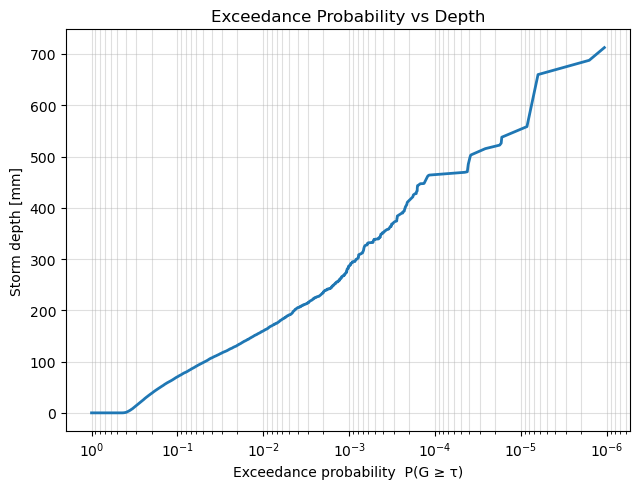

In [34]:
# Make sure weights exist and are finite
assert "depth_mm" in samples_with_weights.columns
assert "w_jt_uniform" in samples_with_weights.columns

sw = samples_with_weights[["depth_mm", "w_jt_uniform"]].dropna().copy()
sw = sw[sw["w_jt_uniform"] > 0]

# Normalize weights once
sw["w_norm"] = sw["w_jt_uniform"] / sw["w_jt_uniform"].sum()

# Aggregate by unique depth (optional but cleaner)
g = (sw.groupby("depth_mm", as_index=False)["w_norm"]
       .sum()
       .sort_values("depth_mm"))           # ascending depths

# Exceedance P(G >= τ) = reverse cumulative of weight mass
g["exc_prob"] = g["w_norm"][::-1].cumsum()[::-1]

# Sanity checks
print("sum weights (should be 1):", g["w_norm"].sum())
print("EP at min depth (≈1):", float(g["exc_prob"].iloc[0]))
print("EP at max depth (small):", float(g["exc_prob"].iloc[-1]))

# Sort by exceedance probability so the line draws in order
curve = g.sort_values("exc_prob").reset_index(drop=True)

import matplotlib.pyplot as plt

plt.figure(figsize=(6.5,5))
plt.plot(curve["exc_prob"], curve["depth_mm"], linewidth=2)   # line, no step
plt.xlabel("Exceedance probability  P(G ≥ τ)")
plt.ylabel("Storm depth [mm]")
plt.grid(True, which="both", alpha=0.4)

# Optional: log x-axis and show high probs on the left (common in hydro)
plt.xscale("log")
plt.gca().invert_xaxis()          # 1 → left, small probs → right

plt.title("Exceedance Probability vs Depth")
plt.tight_layout()
plt.show()


   depth_mm  exc_prob       AEP  RP_years
0  0.000000  1.000000  0.999955  1.000045
1  0.000877  0.439952  0.987717  1.012436
2  0.001754  0.439118  0.987614  1.012541
3  0.002632  0.438517  0.987539  1.012618
4  0.002632  0.438345  0.987518  1.012640


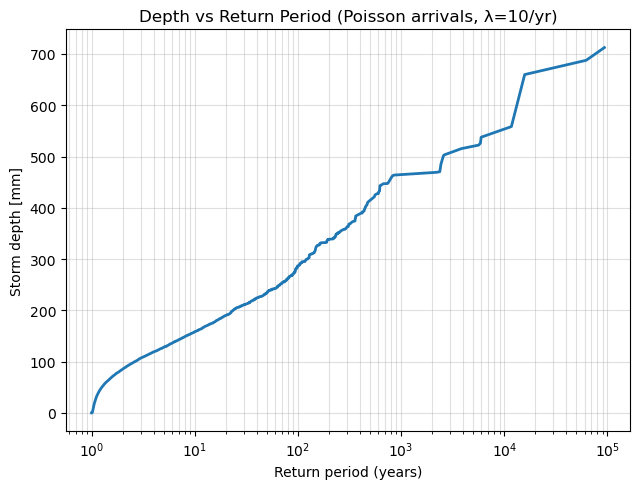

In [37]:
# Assume: g has columns ["depth_mm", "exc_prob"]
lam = 10.0  # storms per year

curve = g.copy()
curve["exc_prob"] = curve["exc_prob"].clip(0, 1)

# Annual exceedance probability from Poisson arrivals
curve["AEP"] = 1.0 - np.exp(-lam * curve["exc_prob"])

# Return period in years
curve["RP_years"] = np.where(curve["AEP"] > 0, 1.0 / curve["AEP"], np.inf)

# (Optional) small-p approximation check: RP ≈ 1/(lam * p)
curve["RP_approx"] = np.where(curve["exc_prob"] > 0, 1.0 / (lam * curve["exc_prob"]), np.inf)

# Quick sanity prints
print(curve[["depth_mm","exc_prob","AEP","RP_years"]].head())

# Plot: Return period (x) vs Depth (y)
curve_plot = curve.sort_values("RP_years")

plt.figure(figsize=(6.5,5))
plt.plot(curve_plot["RP_years"], curve_plot["depth_mm"], linewidth=2)
plt.xscale("log")
plt.xlabel("Return period (years)")
plt.ylabel("Storm depth [mm]")
plt.grid(True, which="both", alpha=0.4)
plt.title("Depth vs Return Period (Poisson arrivals, λ=10/yr)")
plt.tight_layout()
plt.show()

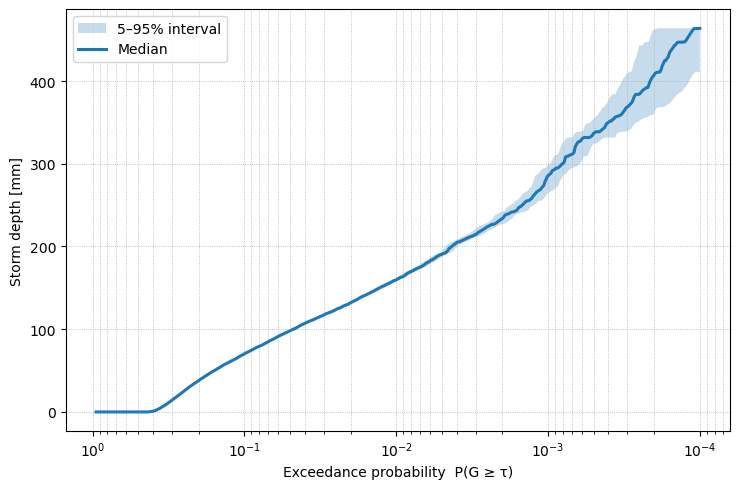

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Input (must exist): samples_with_weights with columns depth_mm, w_jt_uniform
# Optionally: a 'rep' column (then we use real replicates)
df_sw = samples_with_weights[["depth_mm","w_jt_uniform"] + (["rep"] if "rep" in samples_with_weights.columns else [])].dropna().copy()

# Exceedance-probability grid (log-spaced, small→large)
ep_grid = np.geomspace(1e-4, 0.95, 500)

# Build per-replicate (or bootstrap) groups
groups = []
if "rep" in df_sw.columns:
    for _, g in df_sw.groupby("rep"):
        groups.append(g[["depth_mm","w_jt_uniform"]].copy())
else:
    # Weighted bootstrap to get uncertainty
    R = 200
    N = len(df_sw)
    p = (df_sw["w_jt_uniform"] / df_sw["w_jt_uniform"].sum()).to_numpy()
    depth_all = df_sw["depth_mm"].to_numpy()
    rng = np.random.default_rng(42)
    for r in range(R):
        idx = rng.choice(N, size=N, replace=True, p=p)
        # Treat bootstrap samples as equally weighted (already drawn ∝ target)
        groups.append(pd.DataFrame({"depth_mm": depth_all[idx], "w_jt_uniform": np.ones(N)/N}))

# Compute EP→depth curve for each group, interpolate onto ep_grid
curves = []
for g in groups:
    g = g[g["w_jt_uniform"] > 0].dropna().copy()
    if g.empty:
        curves.append(np.full_like(ep_grid, np.nan, dtype=float)); continue

    # Normalize weights within group
    g["w_norm"] = g["w_jt_uniform"] / g["w_jt_uniform"].sum()

    # Sort by depth (ascending), build CDF then EP = 1 - CDF
    g = g.sort_values("depth_mm")
    cdf = g["w_norm"].cumsum().to_numpy()
    ep  = 1.0 - cdf                      # decreases with depth
    depth = g["depth_mm"].to_numpy()

    # Interpolate depth at requested EP grid (need EP increasing for interp)
    x = np.clip(ep[::-1], 1e-12, 0.999999)  # now increasing
    y = depth[::-1]
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 2:
        curves.append(np.full_like(ep_grid, np.nan, dtype=float)); continue

    y_interp = np.interp(np.log(ep_grid), np.log(x[m]), y[m], left=np.nan, right=np.nan)
    curves.append(y_interp)

curves = np.vstack(curves)

# 5–95% band + median
q_lo, q_med, q_hi = np.nanpercentile(curves, [5, 50, 95], axis=0)
m_band = np.isfinite(q_lo) & np.isfinite(q_hi)
m_med  = np.isfinite(q_med)

# ---- Plot: EP on x (log), Depth on y; no step
fig, ax = plt.subplots(figsize=(7.5,5))
ax.fill_between(ep_grid[m_band], q_lo[m_band], q_hi[m_band], alpha=0.25, label="5–95% interval")
ax.plot(ep_grid[m_med], q_med[m_med], linewidth=2.2, label="Median")

ax.set_xscale("log")
ax.invert_xaxis()  # 1 on the left, rare events to the right
ax.set_xlabel("Exceedance probability  P(G ≥ τ)")
ax.set_ylabel("Storm depth [mm]")
ax.grid(True, which="both", linestyle=":", linewidth=0.6)
ax.legend()
plt.tight_layout()
plt.show()


In [39]:
import numpy as np
import pandas as pd
from shapely.geometry import Point

# ====== USER SETTINGS ======
N_new   = 100000               # number of new storm centers to draw
a_mode  = "empirical"         # options: "empirical", "neyman", "area"
rng     = np.random.default_rng(42)
# ===========================

# 0) Freeze current active leaves
frozen = leaves.loc[leaves["active"]].copy().reset_index(drop=True)

# 1) Choose leaf-level proposal a_j
#    empirical: proportional to how many samples fell in each leaf so far
#    neyman   : proportional to sqrt(var_j) * area_j (variance-sensitive)
#    area     : proportional to area_j (=> uniform overall; weights = 1)
if a_mode == "empirical" and "leaf_id" in samples.columns:
    counts = samples.groupby("leaf_id").size()
    frozen = frozen.merge(counts.rename("N_j"), on="leaf_id", how="left")
    frozen["N_j"] = frozen["N_j"].fillna(0.0)
    a = frozen["N_j"].to_numpy(dtype=float)
elif a_mode == "neyman":
    a = np.sqrt(frozen["var"].fillna(0.0).to_numpy()) * frozen["area_in_domain"].to_numpy(dtype=float)
else:  # "area"
    a = frozen["area_in_domain"].to_numpy(dtype=float)

# floor + normalize
a = np.clip(a, 1e-12, None)
a = a / a.sum()
frozen["a_j"] = a

# 2) Precompute constant per-leaf weight vs uniform target
#    q(s) = a_j * (1/A_j),   p_target(s) = 1/A_dom  =>  w_j = A_j/(A_dom * a_j)
# NOTE: If you set a_mode="area", then a_j = A_j/A_dom and w_j = 1 (good sanity check).
frozen["w_uniform"] = frozen["area_in_domain"] / (A_domain * frozen["a_j"])

# 3) Decide how many draws to request per leaf
leaf_ids   = frozen["leaf_id"].to_numpy()
leaf_probs = frozen["a_j"].to_numpy()
leaf_choice_pos = rng.choice(len(leaf_ids), size=N_new, p=leaf_probs)
K_per_leaf = np.bincount(leaf_choice_pos, minlength=len(leaf_ids))

# 4) Draw points uniformly inside each leaf ∩ domain (bbox + polygon rejection)
rows = []
for pos, K in enumerate(K_per_leaf):
    if K <= 0:
        continue
    row = frozen.iloc[pos]
    x0, x1, y0, y1 = row["x_min"], row["x_max"], row["y_min"], row["y_max"]
    lid = row["leaf_id"]
    wj  = float(row["w_uniform"])
    kept = 0
    attempts = 0
    max_attempts = max(K * 200, 5000)  # be generous for slivery leaves

    while kept < K and attempts < max_attempts:
        attempts += 1
        xr = rng.uniform(x0, x1)
        yr = rng.uniform(y0, y1)
        if domain_geom.contains(Point(xr, yr)):
            rows.append({"leaf_id": lid, "x": xr, "y": yr, "w_uniform": wj, "a_j": float(row["a_j"])})
            kept += 1

    if kept < K:
        print(f"[resample] WARN leaf {int(lid)}: planned={K}, kept={kept}, attempts={attempts}")

resampled = pd.DataFrame(rows)

print(f"Made {len(resampled)} new samples "
      f"(requested {N_new}).  Sum of weights ≈ {resampled['w_uniform'].sum():.4f}")

# Optional: quick checks
# - If a_mode == "area", weights should all be 1:
if a_mode == "area":
    uniq = np.unique(resampled["w_uniform"])
    print("Unique weights (should be [1.0]):", uniq[:5], "… count:", len(uniq))
# - Basic sanity: weights should be positive
assert (resampled["w_uniform"] > 0).all()


[resample] WARN leaf 2224: planned=32, kept=26, attempts=6400
[resample] WARN leaf 2229: planned=47, kept=41, attempts=9400
[resample] WARN leaf 2230: planned=40, kept=26, attempts=8000
Made 99974 new samples (requested 100000).  Sum of weights ≈ 59208.8599


/tmp/ipykernel_41618/1315715078.py:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right")


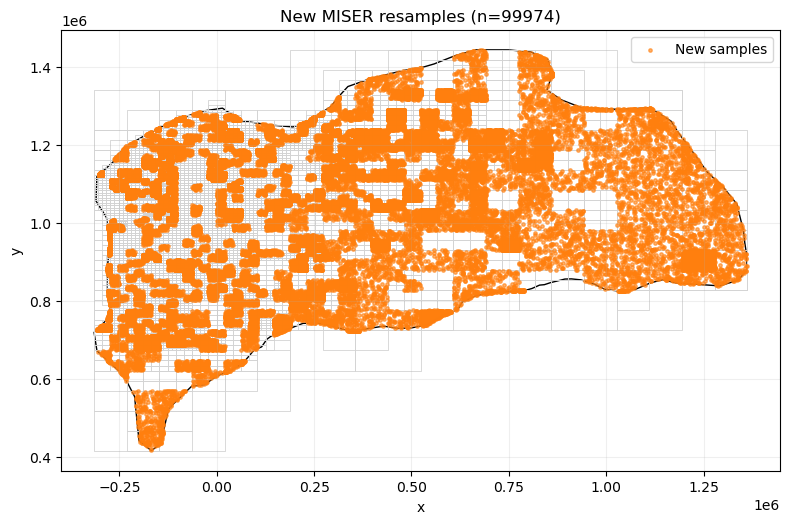

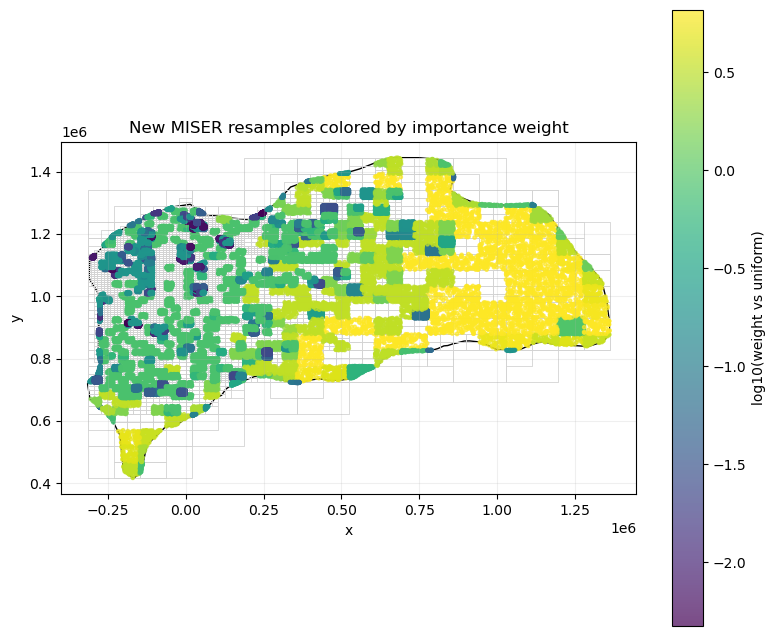

In [40]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
import numpy as np

# Build/refresh leaf_gdf if not already in scope
leaf_polys = [box(r["x_min"], r["y_min"], r["x_max"], r["y_max"]) for _, r in leaves.iterrows()]
leaf_gdf = gpd.GeoDataFrame(leaves.copy(), geometry=leaf_polys, crs=domain_gdf.crs)

if resampled.empty:
    print("No new samples in `resampled`.")
else:
    fig, ax = plt.subplots(figsize=(8,8))

    # Domain boundary
    gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).plot(
        ax=ax, facecolor="none", edgecolor="black", linewidth=1.0, label="Domain"
    )

    # Leaves (light outlines)
    leaf_gdf.plot(ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.6, label="Leaves")

    # --- Option A: simple scatter (uniform color) ---
    ax.scatter(resampled["x"], resampled["y"], s=6, alpha=0.6, color="tab:orange", label="New samples")

    ax.set_aspect("equal")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(f"New MISER resamples (n={len(resampled)})")
    ax.grid(True, alpha=0.2)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    # --- Option B: color by importance weight (log10 scale) ---
    fig, ax = plt.subplots(figsize=(8,8))
    gpd.GeoSeries([domain_geom], crs=domain_gdf.crs).plot(
        ax=ax, facecolor="none", edgecolor="black", linewidth=1.0
    )
    leaf_gdf.plot(ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.6)

    w = resampled["w_uniform"].to_numpy(dtype=float)
    w = np.where(w > 0, w, np.nan)
    sc = ax.scatter(resampled["x"], resampled["y"], s=6, alpha=0.7,
                    c=np.log10(w), cmap="viridis")
    cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
    cbar.set_label("log10(weight vs uniform)")

    ax.set_aspect("equal")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title("New MISER resamples colored by importance weight")
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
